In [14]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# Load the merged outcome file
df = pd.read_csv("outcome_merged.csv")

# Create the column name for each run's difference
df['dif_label'] = 'dif_' + df['run_id']

# Select relevant columns
df = df[['comboID', 'dif_label', 'Difference (%)']]

# Aggregate duplicates by taking the mean Difference (%) for each comboID and run
df_agg = df.groupby(['comboID', 'dif_label'])['Difference (%)'].mean().reset_index()

# Pivot the table
pivot_df = df_agg.pivot(index='comboID', columns='dif_label', values='Difference (%)')



In [3]:
pivot_df

dif_label,dif_Felix1,dif_Felix2,dif_Felix3,dif_Felix4,dif_Felix5
comboID,,,,,
0,18.36,25.25,31.7,1.2,21.0
1,25.62,5.45,12.8,7.2,26.6
2,4.60,10.70,36.8,26.6,0.2
3,15.86,20.35,20.9,16.3,1.0
4,16.74,4.25,1.1,17.5,6.2
...,...,...,...,...,...
675,23.40,17.80,21.4,20.7,8.2
676,2.70,21.80,20.2,13.0,14.7
677,19.90,2.30,31.4,19.8,27.6


In [4]:


# Calculate statistics across the dif_* columns
pivot_df['mean'] = pivot_df.mean(axis=1, skipna=True)
pivot_df['median'] = pivot_df.median(axis=1, skipna=True)
pivot_df['range'] = pivot_df.max(axis=1, skipna=True) - pivot_df.min(axis=1, skipna=True)
pivot_df['std_dev'] = pivot_df.std(axis=1, skipna=True) 

# Reset index to make comboID a column again
pivot_df = pivot_df.reset_index()

# Save to new file
pivot_df.to_csv("comboID_summary.csv", index=False)

print("Summary saved as comboID_summary.csv")


Summary saved as comboID_summary.csv


In [5]:
pivot_df

dif_label,comboID,dif_Felix1,dif_Felix2,dif_Felix3,dif_Felix4,dif_Felix5,mean,median,range,std_dev
0,0,18.36,25.25,31.7,1.2,21.0,19.502,20.251,30.50,9.446164
1,1,25.62,5.45,12.8,7.2,26.6,15.534,14.167,21.15,7.873577
2,2,4.60,10.70,36.8,26.6,0.2,15.780,13.240,36.60,13.890399
3,3,15.86,20.35,20.9,16.3,1.0,14.882,16.080,19.90,6.364838
4,4,16.74,4.25,1.1,17.5,6.2,9.158,7.679,16.40,6.271566
...,...,...,...,...,...,...,...,...,...,...
675,675,23.40,17.80,21.4,20.7,8.2,18.300,19.500,15.20,4.694050
676,676,2.70,21.80,20.2,13.0,14.7,14.480,14.590,19.10,5.926549
677,677,19.90,2.30,31.4,19.8,27.6,20.200,20.050,29.10,9.027911
678,678,30.20,26.10,31.9,25.3,NaN,28.375,28.375,6.60,8.532314


In [6]:
# Load the summary file
summary_df = pd.read_csv("comboID_summary.csv")

# Describe the 'range' column
range_description = summary_df['range'].describe()

# Print summary statistics
print("Range Column Summary Statistics:")
print(range_description)

Range Column Summary Statistics:
count    680.000000
mean      13.811103
std        6.570703
min        1.200000
25%        8.600000
50%       13.200000
75%       17.925000
max       36.600000
Name: range, dtype: float64


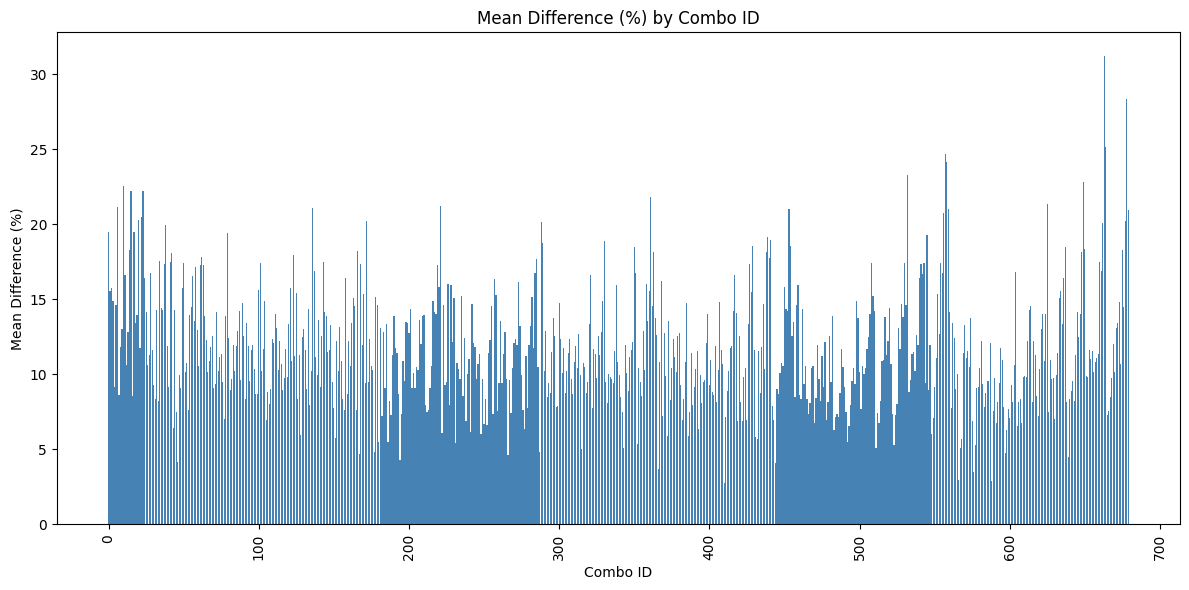

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.bar(summary_df['comboID'], summary_df['mean'], color='steelblue')
plt.xlabel('Combo ID')
plt.ylabel('Mean Difference (%)')
plt.title('Mean Difference (%) by Combo ID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
summary_df.columns

Index(['comboID', 'dif_Felix1', 'dif_Felix2', 'dif_Felix3', 'dif_Felix4',
       'dif_Felix5', 'mean', 'median', 'range', 'std_dev'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import t

# Step 2: Calculate 95% confidence intervals for the mean
n = 4
df = n - 1
t_score = t.ppf(0.975, df)  # 95% CI two-tailed for df=3 ≈ 3.182
summary_df['ci_lower'] = summary_df['mean'] - t_score * (summary_df['std_dev'] / np.sqrt(n))
summary_df['ci_upper'] = summary_df['mean'] + t_score * (summary_df['std_dev'] / np.sqrt(n))

# Step 3: Determine the best observed mean performance (lowest % difference)
best_mean = summary_df['mean'].min()

# Step 4: Tagging combos based on confidence interval comparison
def tag_combo(row, best_mean):
    if row['ci_lower'] > best_mean + 10:
        return 'Eliminate'
    elif row['ci_upper'] < best_mean + 5:
        return 'Prioritize'
    else:
        return 'Explore'

summary_df['tag'] = summary_df.apply(lambda row: tag_combo(row, best_mean), axis=1)

# Step 5: sort for review
summary_df = summary_df.sort_values(by=['tag', 'mean'])

# Output result
summary_df[['comboID', 'mean', 'std_dev', 'ci_lower', 'ci_upper', 'tag']]


,comboID,mean,std_dev,ci_lower,ci_upper,tag
556,556,20.7750,4.896904,12.982932,28.567068,Eliminate
453,453,21.0000,4.817750,13.333885,28.666115,Eliminate
136,136,21.1000,5.196931,12.830523,29.369477,Eliminate
361,361,21.8400,5.627275,12.885750,30.794250,Eliminate
23,23,22.2125,5.439192,13.557531,30.867469,Eliminate
...,...,...,...,...,...,...
266,266,4.6400,1.330493,2.522888,6.757112,Prioritize
167,167,4.6600,1.770371,1.842945,7.477055,Prioritize
287,287,4.8200,1.647027,2.199212,7.440788,Prioritize
177,177,4.8400,1.081850,3.118535,6.561465,Prioritize


## Stats

In [15]:


# Total mean (average of means)
total_mean = summary_df['mean'].mean()

# Average standard deviation
average_std = summary_df['std_dev'].mean()

# 95% Confidence Interval of the total mean
n = len(summary_df)
std_err = summary_df['mean'].std(ddof=1) / np.sqrt(n)
ci_bounds = stats.t.interval(0.95, df=n-1, loc=total_mean, scale=std_err)

print("Total Mean:", total_mean)
print("Average SD:", average_std)
print("95% CI of Mean:", ci_bounds)


Total Mean: 11.610844362745098
Average SD: 4.901450220501587
95% CI of Mean: (np.float64(11.315175175793268), np.float64(11.906513549696928))


In [10]:
# Function to perform sensitivity analysis
def sensitivity_analysis(summary_df, best_mean, eliminate_thresholds, prioritize_thresholds):
    results = []
    for elim_threshold in eliminate_thresholds:
        for prior_threshold in prioritize_thresholds:
            # Tagging combos based on confidence interval comparison
            def tag_combo(row, best_mean, elim_threshold, prior_threshold):
                if row['ci_lower'] > best_mean + elim_threshold:
                    return 'Eliminate'
                elif row['ci_upper'] < best_mean + prior_threshold:
                    return 'Prioritize'
                else:
                    return 'Explore'

            summary_df['tag'] = summary_df.apply(lambda row: tag_combo(row, best_mean, elim_threshold, prior_threshold), axis=1)

            # Count the number of combos in each tag category
            tag_counts = summary_df['tag'].value_counts().to_dict()

            # Store the results
            results.append({
                'eliminate_threshold': elim_threshold,
                'prioritize_threshold': prior_threshold,
                'tag_counts': tag_counts
            })

    return pd.DataFrame(results)

# Define ranges for the thresholds
eliminate_thresholds = range(5, 16, 5)  # Example: 5, 10, 15
prioritize_thresholds = range(1, 6, 2)  # Example: 1, 3, 5

# Perform sensitivity analysis
sensitivity_results = sensitivity_analysis(summary_df, best_mean, eliminate_thresholds, prioritize_thresholds)

# Output the sensitivity analysis results
print(sensitivity_results)


   eliminate_threshold  prioritize_threshold  \
0                    5                     1   
1                    5                     3   
2                    5                     5   
3                   10                     1   
4                   10                     3   
5                   10                     5   
6                   15                     1   
7                   15                     3   
8                   15                     5   

                                          tag_counts  
0                 {'Explore': 577, 'Eliminate': 103}  
1  {'Explore': 575, 'Eliminate': 103, 'Prioritize...  
2  {'Explore': 565, 'Eliminate': 103, 'Prioritize...  
3                  {'Explore': 667, 'Eliminate': 13}  
4  {'Explore': 665, 'Eliminate': 13, 'Prioritize'...  
5  {'Explore': 655, 'Eliminate': 13, 'Prioritize'...  
6                                   {'Explore': 680}  
7                  {'Explore': 678, 'Prioritize': 2}  
8                 {'Expl

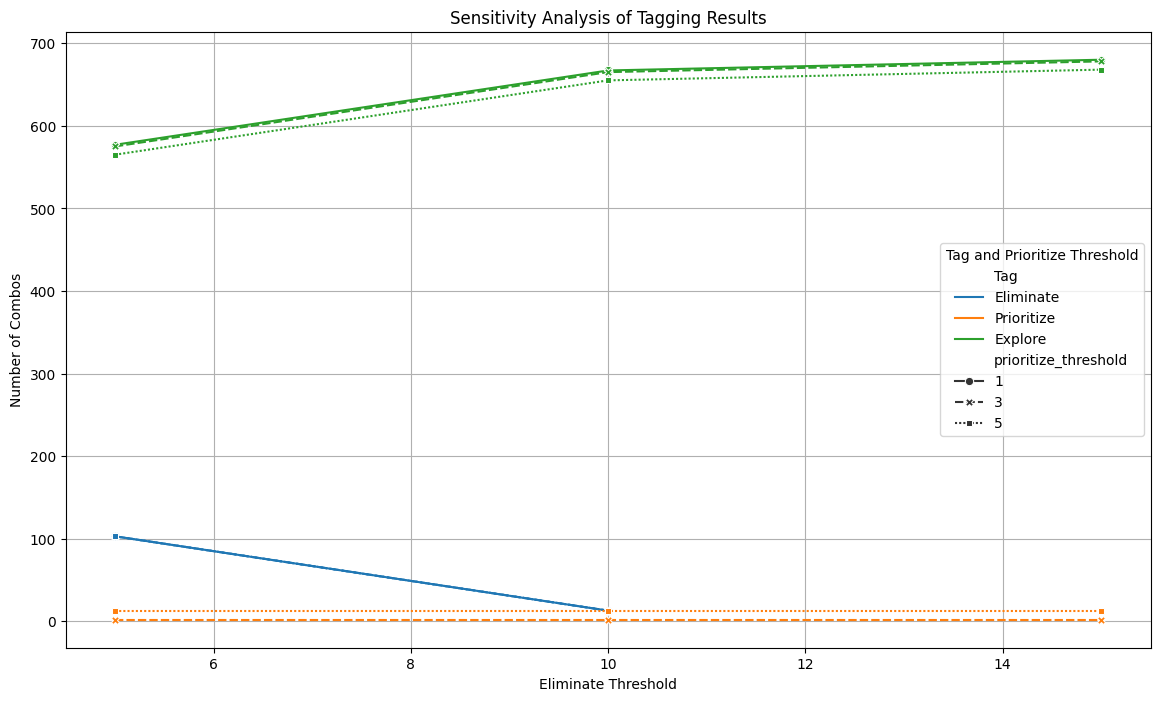

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sensitivity_results is the DataFrame from the sensitivity analysis
# Convert the tag_counts dictionary into separate columns for easier plotting
sensitivity_results = sensitivity_results.join(pd.DataFrame(sensitivity_results['tag_counts'].tolist()))

# Melt the DataFrame to long format for seaborn plotting
melted_results = sensitivity_results.melt(id_vars=['eliminate_threshold', 'prioritize_threshold'],
                                           value_vars=['Eliminate', 'Prioritize', 'Explore'],
                                           var_name='Tag', value_name='Count')

# Plot the sensitivity analysis results
plt.figure(figsize=(14, 8))
sns.lineplot(data=melted_results, x='eliminate_threshold', y='Count', hue='Tag', style='prioritize_threshold', markers=True)
plt.title('Sensitivity Analysis of Tagging Results')
plt.xlabel('Eliminate Threshold')
plt.ylabel('Number of Combos')
plt.legend(title='Tag and Prioritize Threshold')
plt.grid(True)
plt.show()


In [12]:
import pandas as pd

# Assuming summary_df is your DataFrame with columns 'ci_lower' and 'ci_upper'
summary_df['ci_width'] = summary_df['ci_upper'] - summary_df['ci_lower']

# Calculate the average confidence interval width
average_ci_width = summary_df['ci_width'].mean()

# Determine a benchmark (example: 10% of the mean difference)
benchmark = 0.10 * summary_df['mean'].mean()

# Compare the average confidence interval width to the benchmark
if average_ci_width < benchmark:
    print("The confidence intervals are generally narrow.")
else:
    print("The confidence intervals are generally wide.")

print(f"Average Confidence Interval Width: {average_ci_width}")
print(f"Benchmark: {benchmark}")


The confidence intervals are generally wide.
Average Confidence Interval Width: 15.59860214477001
Benchmark: 1.1610844362745099


In [ ]:
# Count how many of each tag
tag_counts = summary_df['tag'].value_counts()

# Display the result
print("Tag distribution:")
print(tag_counts)


Tag distribution:
tag
Explore       668
Prioritize     12
Name: count, dtype: int64


# Filtering Combos


In [ ]:
action_df = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/0.5 - Summer 25/MGSC 670 - Revenue Management/Assignement/Retail_Mardown_Game/Retail_Mardown_Game/action_df.csv")


In [ ]:
# Get list of comboIDs tagged as 'Prioritize'
prioritize_combos = summary_df[summary_df['tag'] == 'Prioritize']['comboID'].tolist()
print("Combo IDs tagged as 'Prioritize':")
print(prioritize_combos)


# Get list of comboIDs tagged as 'Prioritize'
prioritize_combos = summary_df[summary_df['tag'] == 'Prioritize']['comboID'].tolist()
print("Combo IDs tagged as 'Prioritize':")
print(prioritize_combos)

# Create a new DataFrame keeping only prioritized combos
action_df_prioritized = action_df[action_df['combo_number'].isin(prioritize_combos)].copy()

# Save the filtered DataFrame to a new CSV file
action_df_prioritized.to_csv("C:/Users/felix/OneDrive/McGill Master Work/0.5 - Summer 25/MGSC 670 - Revenue Management/Assignement/Retail_Mardown_Game/Retail_Mardown_Game/action_df_prioritized.csv", index=False)

# Show how many rows were kept
print(f"Kept {len(action_df_prioritized)} rows out of {len(action_df)} total rows.")
print(f"Number of prioritized combos: {len(prioritize_combos)}")

# Preview the result
action_df_prioritized.head()

Combo IDs tagged as 'Prioritize':
[410, 588, 566, 576, 366, 444, 46, 266, 167, 287, 177, 492]
Combo IDs tagged as 'Prioritize':
[410, 588, 566, 576, 366, 444, 46, 266, 167, 287, 177, 492]
Kept 12 rows out of 680 total rows.
Number of prioritized combos: 12


,combo_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
46,46,A,A,A,A,A,A,A,A,A,A,B,C,A,A,D
167,167,A,A,A,A,A,A,B,A,A,A,A,A,A,A,D
177,177,A,A,A,A,A,A,B,A,A,A,A,C,A,D,A
266,266,A,A,A,A,A,B,C,A,A,A,A,A,A,A,D
287,287,A,A,A,A,B,A,A,A,A,A,A,A,A,A,C


Index(['combo_number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15'],
      dtype='object')

In [ ]:

# Get list of comboIDs tagged as 'Eliminate'
eliminate_combos = summary_df[summary_df['tag'] == 'Eliminate']['comboID'].tolist()

# Output the list
print("Combos to eliminate:")
print(eliminate_combos)
# Create a new DataFrame excluding eliminated combos
action_df_eliminated = action_df[~action_df['combo_number'].isin(eliminate_combos)].copy()
action_df_eliminated.to_csv("C:/Users/felix/OneDrive/McGill Master Work/0.5 - Summer 25/MGSC 670 - Revenue Management/Assignement/Retail_Mardown_Game/Retail_Mardown_Game/action_df_eliminated.csv", index=False)

# Check how many rows were removed
print(f"Removed {len(action_df) - len(action_df_eliminated)} rows.")
print(f"Remaining rows: {len(action_df_eliminated)}")

# Preview the result
action_df_eliminated.head()


Combos to eliminate:
[556, 136, 23, 15, 532, 558, 557, 664, 678, 663]
Removed 10 rows.
Remaining rows: 670


,combo_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A
1,1,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B
2,2,A,A,A,A,A,A,A,A,A,A,A,A,A,A,C
3,3,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D
4,4,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A


Weekly data shape: (42000, 7)

Weekly data sample:
   Simulation Number  comboID  Week  Price  Sales  Remaining Inventory  run_id
0                  1        0     1     60     82                 1918  Felix1
1                  1        0     2     60     78                 1840  Felix1
2                  1        0     3     60     60                 1780  Felix1
3                  1        0     4     60     79                 1701  Felix1
4                  1        0     5     60     85                 1616  Felix1

Outcome data shape: (2810, 6)

Outcome data sample:
   Simulation Number  comboID  Your revenue  Perfect foresight strategy  \
0                  1        0         64260                       90552   
1                  2        1         49872                       77148   
2                  3        2        101940                      110232   
3                  4        3         91992                      104784   
4                  5        4         39624    

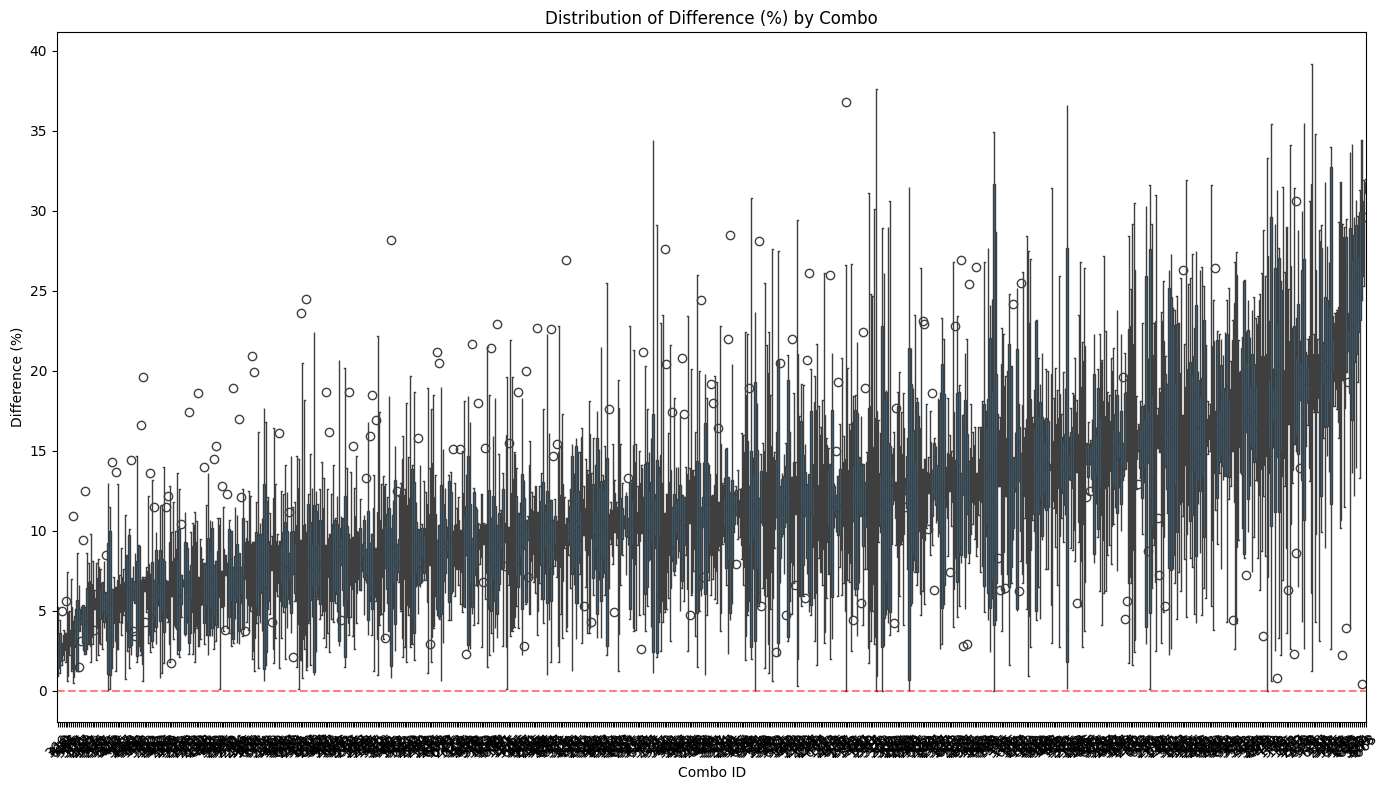

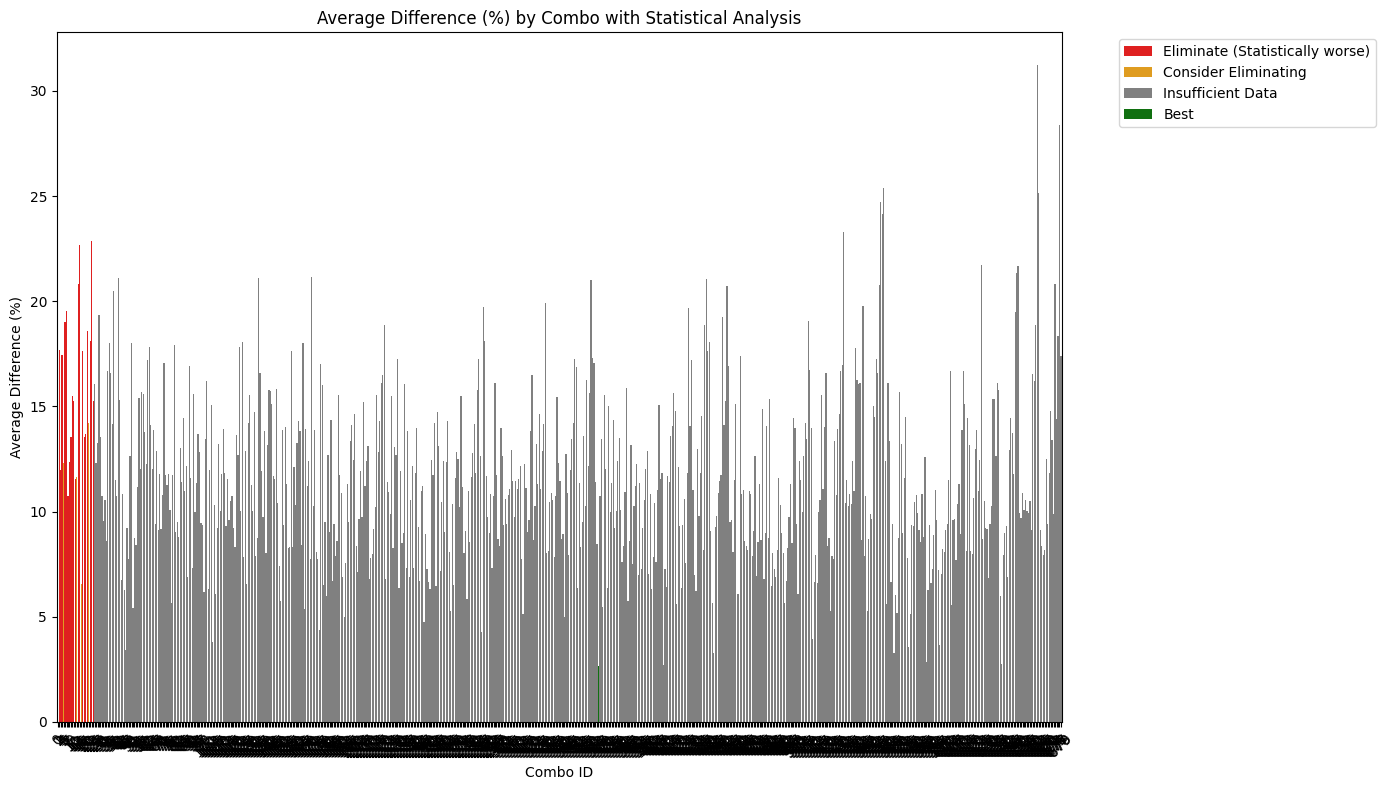

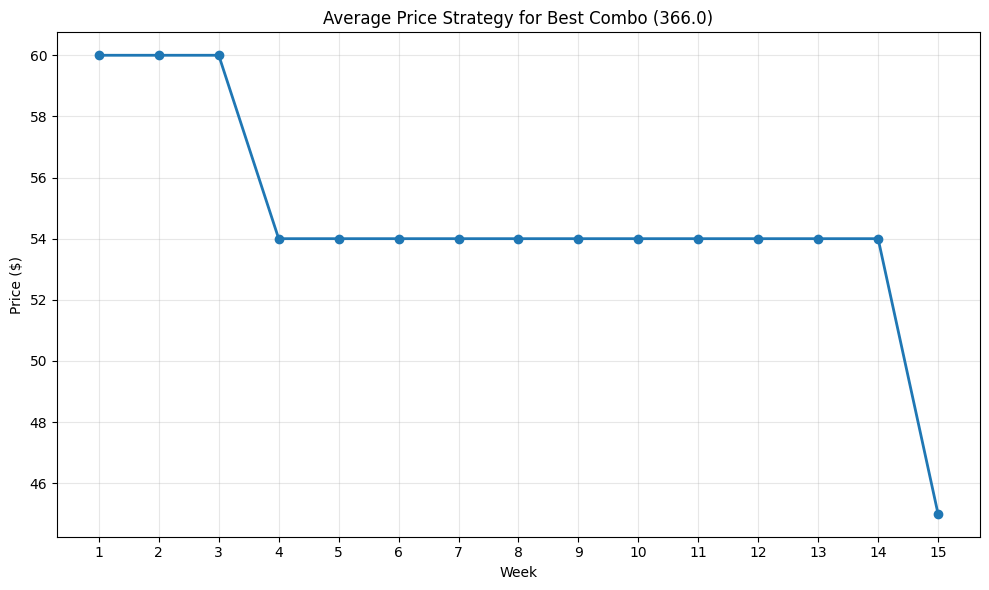

In [ ]:
# import pandas as pd
# import numpy as np
# from scipy.stats import ttest_rel, wilcoxon
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load the weekly data
# df_weekly = pd.read_csv('week_detail_merged.csv')
# print("Weekly data shape:", df_weekly.shape)
# print("\nWeekly data sample:")
# print(df_weekly.head())

# # Load the outcome data
# df_outcome = pd.read_csv('outcome_merged.csv')
# print("\nOutcome data shape:", df_outcome.shape)
# print("\nOutcome data sample:")
# print(df_outcome.head())

# # Display basic information
# print("\nNumber of combos:", df_outcome['comboID'].nunique())
# print("Number of simulations:", df_outcome['run_id'].nunique())

# # Create a summary dataframe with average difference % per combo
# summary_df = df_outcome.groupby('comboID')['Difference (%)'].agg(['mean', 'std', 'count']).reset_index()
# summary_df = summary_df.sort_values('mean', ascending=True)  # Sort by lowest difference % (best performing)

# # Identify the best combo (lowest mean difference %)
# best_combo_id = summary_df.iloc[0]['comboID']
# print(f"\nBest performing combo: {best_combo_id} with mean difference of {summary_df.iloc[0]['mean']:.2f}%")

# # Check for combos that don't exist in all simulations
# all_sims = set(df_outcome['run_id'].unique())
# combo_in_sims = df_outcome.groupby('comboID')['run_id'].unique().apply(set)
# combo_missing_sims = {combo: all_sims - sims for combo, sims in combo_in_sims.items()}

# print("\nCombos missing from some simulations:")
# missing_combos = []
# for combo, missing_sims in combo_missing_sims.items():
#     if len(missing_sims) > 0:
#         print(f"Combo {combo} is missing from {len(missing_sims)} simulations ({len(missing_sims)/len(all_sims)*100:.1f}%)")
#         missing_combos.append((combo, len(missing_sims)/len(all_sims)))

# # Function to perform statistical tests comparing each combo to the best combo
# def perform_statistical_tests(outcome_data, weekly_data, best_combo_id, all_sims):
#     results = []
#     all_combos = outcome_data['comboID'].unique()
    
#     # Get list of simulations for each combo
#     combo_sims = {combo: set(outcome_data[outcome_data['comboID'] == combo]['run_id'].unique()) 
#                   for combo in all_combos}
    
#     for combo_id in all_combos:
#         # Check if combo is missing from any simulations
#         missing_sims = all_sims - combo_sims.get(combo_id, set())
#         missing_ratio = len(missing_sims) / len(all_sims)
        
#         if combo_id == best_combo_id:
#             # The best combo
#             results.append({
#                 'comboID': combo_id,
#                 'ttest_p_value': 1.0,  # No difference with itself
#                 'wilcoxon_p_value': 1.0,  # No difference with itself
#                 'missing_sim_ratio': missing_ratio,
#                 'tag': 'Best'
#             })
#             continue
        
#         # If combo is missing from more than 25% of simulations, eliminate it
#         if missing_ratio > 0.25:
#             results.append({
#                 'comboID': combo_id,
#                 'ttest_p_value': np.nan,
#                 'wilcoxon_p_value': np.nan,
#                 'missing_sim_ratio': missing_ratio,
#                 'tag': 'Eliminate (Missing from multiple runs)'
#             })
#             continue
        
#         # Get the difference % data for this combo and the best combo
#         combo_data = outcome_data[outcome_data['comboID'] == combo_id]
#         best_combo_data = outcome_data[outcome_data['comboID'] == best_combo_id]
        
#         # Merge data to compare on the same simulations
#         merged_data = pd.merge(
#             combo_data[['run_id', 'Difference (%)']],
#             best_combo_data[['run_id', 'Difference (%)']],
#             on='run_id',
#             suffixes=('_combo', '_best')
#         )
        
#         # Skip if not enough paired data
#         if len(merged_data) < 5:
#             results.append({
#                 'comboID': combo_id,
#                 'ttest_p_value': np.nan,
#                 'wilcoxon_p_value': np.nan,
#                 'missing_sim_ratio': missing_ratio,
#                 'tag': 'Insufficient Data'
#             })
#             continue
        
#         # Perform paired t-test - we want to test if combo's difference % is statistically higher (worse) than best combo's
#         try:
#             t_stat, p_value_t = ttest_rel(merged_data['Difference (%)_combo'], merged_data['Difference (%)_best'])
#             # Convert to one-tailed p-value if t_stat is positive (combo is worse than best)
#             if t_stat > 0:
#                 p_value_t /= 2
#         except:
#             p_value_t = np.nan
        
#         # Perform Wilcoxon signed-rank test
#         try:
#             # Use one-sided test to check if this combo is statistically worse
#             stat, p_value_w = wilcoxon(
#                 merged_data['Difference (%)_combo'], 
#                 merged_data['Difference (%)_best'],
#                 alternative='greater'  # Test if combo's difference is greater (worse) than best combo's
#             )
#         except:
#             p_value_w = np.nan
        
#         # Calculate the mean difference in performance
#         mean_diff = merged_data['Difference (%)_combo'].mean() - merged_data['Difference (%)_best'].mean()
        
#         # Tag based on statistical significance
#         if not np.isnan(p_value_t) and not np.isnan(p_value_w):
#             if p_value_t < 0.05 and p_value_w < 0.05:
#                 tag = 'Eliminate (Statistically worse)'
#             elif p_value_t < 0.1 or p_value_w < 0.1:
#                 tag = 'Consider Eliminating'
#             else:
#                 tag = 'Explore'
#         else:
#             tag = 'Explore'
        
#         results.append({
#             'comboID': combo_id,
#             'ttest_p_value': p_value_t,
#             'wilcoxon_p_value': p_value_w,
#             'mean_diff_from_best': mean_diff,
#             'missing_sim_ratio': missing_ratio,
#             'tag': tag
#         })
    
#     return pd.DataFrame(results)

# # Run the statistical tests
# results_df = perform_statistical_tests(df_outcome, df_weekly, best_combo_id, all_sims)

# # Merge the statistical results with the summary dataframe
# final_df = pd.merge(summary_df, results_df, on='comboID', how='left')

# # Sort by mean difference % (ascending)
# final_df = final_df.sort_values('mean', ascending=True)

# # Print the final analysis results
# print("\nFinal Analysis Results:")
# print(final_df[['comboID', 'mean', 'std', 'count', 'ttest_p_value', 'wilcoxon_p_value', 'missing_sim_ratio', 'tag']])

# # Save the results to CSV
# final_df.to_csv('combo_statistical_analysis.csv', index=False)
# print("\nResults saved to combo_statistical_analysis.csv")

# # Visualize the distribution of difference % by combo
# plt.figure(figsize=(14, 8))
# sns.boxplot(x='comboID', y='Difference (%)', data=df_outcome, order=final_df['comboID'].tolist())
# plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
# plt.title('Distribution of Difference (%) by Combo')
# plt.xlabel('Combo ID')
# plt.ylabel('Difference (%)')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig('combo_difference_distribution.png')
# print("\nDifference distribution visualization saved to combo_difference_distribution.png")

# # Create a bar chart with confidence intervals
# plt.figure(figsize=(14, 8))
# sns.barplot(x='comboID', y='mean', data=final_df, 
#             hue='tag', 
#             palette={'Best': 'green', 'Explore': 'blue', 'Consider Eliminating': 'orange', 
#                     'Eliminate (Statistically worse)': 'red', 'Eliminate (Missing from multiple runs)': 'purple', 
#                     'Insufficient Data': 'gray'})
# plt.title('Average Difference (%) by Combo with Statistical Analysis')
# plt.xlabel('Combo ID')
# plt.ylabel('Average Difference (%)')
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.savefig('combo_performance_difference.png')
# print("\nPerformance visualization saved to combo_performance_difference.png")

# # Get weekly performance for the best combo
# if len(df_weekly) > 0:
#     best_weekly = df_weekly[df_weekly['comboID'] == best_combo_id].copy()
    
#     # Group by week and calculate average stats
#     best_weekly_avg = best_weekly.groupby('Week').agg({
#         'Price': 'mean',
#         'Sales': 'mean',
#         'Remaining Inventory': 'mean'
#     }).reset_index()
    
#     print("\nWeekly performance for best combo (averaged across simulations):")
#     print(best_weekly_avg)
    
#     # Plot the price curve for the best combo
#     plt.figure(figsize=(10, 6))
#     plt.plot(best_weekly_avg['Week'], best_weekly_avg['Price'], marker='o', linewidth=2)
#     plt.title(f'Average Price Strategy for Best Combo ({best_combo_id})')
#     plt.xlabel('Week')
#     plt.ylabel('Price ($)')
#     plt.grid(True, alpha=0.3)
#     plt.xticks(range(1, 16))  # 15 weeks
#     plt.tight_layout()
#     plt.savefig('best_combo_price_strategy.png')
#     print("\nBest combo price strategy saved to best_combo_price_strategy.png")
    
#     # Count the frequency of price points at each week for the best combo
#     weekly_price_counts = {}
#     for week in range(1, 16):
#         week_prices = best_weekly[best_weekly['Week'] == week]['Price'].value_counts().to_dict()
#         weekly_price_counts[week] = week_prices
    
#     print("\nPrice distribution by week for best combo:")
#     for week, prices in weekly_price_counts.items():
#         print(f"Week {week}: {prices}")

# print("\nAnalysis complete!")

In [ ]:
# import pandas as pd

# # First, run the analysis to get our final_df with elimination tags
# # This assumes the previous analysis has been run and final_df is loaded
# # If not, you would need to run that code first

# # Load the results from the previous analysis
# try:
#     final_df = pd.read_csv('combo_statistical_analysis.csv')
#     print("Loaded existing analysis results")
# except:
#     print("Please run the previous analysis code first to generate combo_statistical_analysis.csv")
#     # Here you could import and run the previous code if needed

# # Get list of all comboIDs tagged for elimination
# # Include both "Eliminate (Statistically worse)" and "Eliminate (Missing from multiple runs)"
# eliminate_combos = final_df[final_df['tag'].str.startswith('Eliminate')]['comboID'].tolist()

# # print("Combos to eliminate:")
# # for combo in eliminate_combos:
# #     print(f"- {combo}")

# print(f"\nTotal combos to eliminate: {len(eliminate_combos)}")

# # Load your action_df file
# # Assuming the file path; adjust as needed
# try:
#     # First try with a standard path
#     action_df = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/0.5 - Summer 25/MGSC 670 - Revenue Management/Assignement/Retail_Mardown_Game/Retail_Mardown_Game/action_df.csv")

# except:
#     # If that fails, ask for path input
#     print("\nCouldn't find action_df.csv in the current directory.")
#     print("Please provide the full path to your action_df.csv file:")
#     file_path = input()
#     action_df = pd.read_csv(file_path)

# print(f"\nOriginal action_df shape: {action_df.shape}")

# # Create a new DataFrame excluding eliminated combos
# # Assuming 'combo_number' is the column name in action_df; adjust if it's different
# combo_column = 'combo_number' if 'combo_number' in action_df.columns else 'comboID'
# action_df_eliminated = action_df[~action_df[combo_column].isin(eliminate_combos)].copy()

# # Show how many rows were removed
# print(f"Removed {len(action_df) - len(action_df_eliminated)} rows.")
# print(f"Remaining rows: {len(action_df_eliminated)}")

# # Create a summary of what combinations remain
# remaining_combos = action_df_eliminated[combo_column].unique()
# print(f"\nRemaining {len(remaining_combos)} combos:")
# print(remaining_combos)

# # Save the filtered DataFrame
# output_path = "action_df_eliminated_2.csv"
# action_df_eliminated.to_csv(output_path, index=False)
# print(f"\nSaved filtered action dataframe to {output_path}")

# # Consider eliminating
# if 'Consider Eliminating' in final_df['tag'].values:
#     consider_eliminating = final_df[final_df['tag'] == 'Consider Eliminating']['comboID'].tolist()
#     if consider_eliminating:
#         print("\nCombos to consider eliminating (not yet removed):")
#         for combo in consider_eliminating:
#             print(f"- {combo}")

# print("\nPreview of the filtered dataframe:")
# print(action_df_eliminated.head())
# print(action_df_eliminated.shape)


Loaded existing analysis results

Total combos to eliminate: 21

Original action_df shape: (680, 16)
Removed 21 rows.
Remaining rows: 659

Remaining 659 combos:
[  4  13  16  21  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227

In [ ]:
# Count how many of each tag
tag_counts = final_df['tag'].value_counts()

# Display the result
print("Tag distribution:")
print(tag_counts)

Tag distribution:
tag
Insufficient Data                  654
Eliminate (Statistically worse)     21
Consider Eliminating                 4
Best                                 1
Name: count, dtype: int64
